# 판매건수 vs 리뷰건수 분석
## 목표: 유의 판매자 분석의 기준 지표 선정

### 분석 단계
1. 데이터 집계 (판매건수 vs 리뷰건수)
2.  상관관계 확인


In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('Olist_DataSet/ML_olist.csv')

## 1단계: 데이터 집계 (판매건수 vs 리뷰건수)

**정의**:
- **판매건수(order_count)**: 각 판매자가 처리한 총 주문 수 (order_id 기준 집계)
- **리뷰건수(review_count)**: 각 판매자가 받은 총 리뷰 수 (review_score가 존재하는 건수)
- **텍스트리뷰건수(text_review_count)**: 실제 텍스트 리뷰가 있는 건수 (has_text_review=True)


In [207]:
# 판매자별 집계 데이터 생성
seller_stats = df.groupby('seller_id').agg(
    # 판매건수: 고유 주문 수
    order_count=('order_id', 'nunique'),
    # 총 아이템 판매 수 (중복 포함)
    total_items=('order_id', 'count'),
    # 리뷰건수: review_score가 있는 건수
    review_count=('review_score', lambda x: x.notna().sum()),
    # 텍스트 리뷰건수
    text_review_count=('has_text_review', 'sum'),
    # 평균 리뷰 점수
    avg_review_score=('review_score', 'mean'),
    # 부정 리뷰 건수 (1~3점)
    negative_review_count=('review_score', lambda x: (x <= 3).sum()),
    # 긍정 리뷰 건수 (4~5점)
    positive_review_count=('review_score', lambda x: (x >= 4).sum())
).reset_index()

# 리뷰율 계산 (리뷰건수 / 판매건수)
seller_stats['review_rate'] = seller_stats['review_count'] / seller_stats['order_count']
# 텍스트 리뷰율
seller_stats['text_review_rate'] = seller_stats['text_review_count'] / seller_stats['review_count']
# 부정 리뷰 비율
seller_stats['negative_review_rate'] = seller_stats['negative_review_count'] / seller_stats['review_count']

print(f"총 판매자 수: {len(seller_stats)}")
seller_stats.head(10).T


총 판매자 수: 2817


,0,1,2,3,4,5,6,7,8,9
seller_id,0015a82c2db000af6aaaf3ae2ecb0532,001cca7ae9ae17fb1caed9dfb1094831,002100f778ceb8431b7a1020ff7ab48f,003554e2dce176b5555353e4f3555ac8,004c9cd9d87a3c30c522c48c4fc07416,00720abe85ba0859807595bbf045a33b,00ab3eff1b5192e5f1a63bcecfee11c8,00d8b143d12632bad99c0ad66ad52825,00ee68308b45bc5e2660cd833c3f81cc,00fc707aaaad2d31347cf883cd2dfe10
order_count,1,157,43,1,118,7,1,1,105,88
total_items,1,183,48,1,133,16,1,1,136,120
review_count,1,183,48,1,133,16,1,1,136,120
text_review_count,0,81,11,0,49,12,0,1,40,52
avg_review_score,5.0,4.054645,4.25,5.0,4.300752,3.5,5.0,5.0,4.551471,3.883333
negative_review_count,0,42,11,0,26,9,0,0,13,34
positive_review_count,1,141,37,1,107,7,1,1,123,86
review_rate,1.0,1.165605,1.116279,1.0,1.127119,2.285714,1.0,1.0,1.295238,1.363636
text_review_rate,0.0,0.442623,0.229167,0.0,0.368421,0.75,0.0,1.0,0.294118,0.433333


In [208]:
# 기초 통계량 확인
stats_cols = ['order_count', 'total_items', 'review_count', 'text_review_count', 
              'avg_review_score', 'review_rate', 'text_review_rate', 'negative_review_rate']

print(seller_stats[stats_cols].describe().round(2).T)


                       count   mean    std  min   25%   50%    75%     max
order_count           2817.0  26.92  83.56  1.0  2.00  6.00  19.00  1469.0
total_items           2817.0  30.46  95.41  1.0  2.00  7.00  21.00  1620.0
review_count          2817.0  30.46  95.41  1.0  2.00  7.00  21.00  1620.0
text_review_count     2817.0  12.97  43.29  0.0  1.00  3.00   9.00   789.0
avg_review_score      2817.0   4.23   0.78  1.0  4.00  4.35   4.79     5.0
review_rate           2817.0   1.16   0.46  1.0  1.00  1.00   1.14    15.0
text_review_rate      2817.0   0.42   0.29  0.0  0.24  0.41   0.55     1.0
negative_review_rate  2817.0   0.19   0.24  0.0  0.00  0.13   0.26     1.0


## 2단계: 상관관계 확인

In [209]:
# 상관관계 분석
corr_cols = ['order_count', 'total_items', 'review_count', 'text_review_count', 
             'avg_review_score', 'negative_review_count', 'positive_review_count',
             'review_rate', 'negative_review_rate']

correlation_matrix = seller_stats[corr_cols].corr()


In [210]:
# Pearson 상관계수와 p-value 함께 계산
from scipy.stats import pearsonr, spearmanr

print("=" * 70)
print("판매건수 vs 리뷰건수")
print("=" * 70)

# Pearson 상관계수
pearson_corr, pearson_pvalue = pearsonr(seller_stats['order_count'], seller_stats['review_count'])
print(f"\n[Pearson 상관계수]")
print(f"  상관계수: {pearson_corr:.4f}")
print(f"  p-value: {pearson_pvalue:.2e}")

# Spearman 상관계수 (순위 기반 - 비선형 관계에 더 적합)
spearman_corr, spearman_pvalue = spearmanr(seller_stats['order_count'], seller_stats['review_count'])
print(f"\n[Spearman 순위 상관계수]")
print(f"  상관계수: {spearman_corr:.4f}")
print(f"  p-value: {spearman_pvalue:.2e}")

판매건수 vs 리뷰건수

[Pearson 상관계수]
  상관계수: 0.9934
  p-value: 0.00e+00

[Spearman 순위 상관계수]
  상관계수: 0.9862
  p-value: 0.00e+00


---
# Part 2: 월 & 카테고리 피처 포함 여부 검증

## 목표
1. **월(Month) 피처 검증**: Black Friday & Carnival 기간에 리뷰점수 하락 원인 분석
   - 월별 배송 지연율 / 처리 지연 비율 검토
   - 해당 기간을 ML 피처에 포함할지 결정

2. **카테고리 피처 검증**: 카테고리별 지연율이 리뷰에 미치는 영향
   - 물류사 책임이 없는 경우만 분석 (is_logistics_fault = False)


In [ ]:
merged_df = pd.read_csv('Olist_DataSet/merged_olist.csv')

# 날짜 컬럼 변환
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col])

# 월 추출
merged_df['order_month'] = merged_df['order_purchase_timestamp'].dt.month
merged_df['order_year_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')


## 2-1. 월 피처 검증: Black Friday & Carnival 기간 분석

### 지연 관련 피처 정의 (두 가지 지표 비교)
- **seller_delay_days**: 판매자 지연일 (shipping_limit 대비 실제 인계일 차이, 양수면 지연)
- **processing_days_diff**: 처리 지연 차이 (실제 처리일 - 기대 처리일, 양수면 지연)
- **seller_processing_days**: 판매자 처리 시간 (주문승인 → 물류사 인계)
- **is_logistics_fault**: 물류사 책임 여부 (True면 물류사 책임)


In [212]:
# 특수 기간 vs 일반 기간 비교 (물류사 책임 제외)
# 두 가지 지연 기준 모두 사용
merged_df['is_seller_delayed'] = merged_df['seller_delay_days'] > 0  # shipping_limit 기준
merged_df['is_processing_delayed'] = merged_df['processing_days_diff'] > 0  # 기대 처리시간 기준

# 특수 기간 플래그 생성
merged_df['period_type'] = 'Normal'
merged_df.loc[merged_df['is_black_friday'] == True, 'period_type'] = 'Black Friday'
merged_df.loc[merged_df['is_carnival'] == True, 'period_type'] = 'Carnival'

# 물류사 책임 제외한 데이터
seller_fault_df = merged_df[merged_df['is_logistics_fault'] == False].copy()
print(f"분석 대상: {len(seller_fault_df):,}건 (물류사 책임 {len(merged_df) - len(seller_fault_df):,}건 제외)")

# 물류사 책임 비율은 전체 데이터에서 계산 (참고용)
logistics_fault_by_period = merged_df.groupby('period_type')['is_logistics_fault'].mean()

# 기간별 통계 (물류사 책임 제외)
period_stats = seller_fault_df.groupby('period_type').agg(
    total_orders=('order_id', 'count'),
    avg_review_score=('review_score', 'mean'),
    avg_seller_processing=('seller_processing_days', 'mean'),
    # seller_delay_days 관련
    avg_seller_delay=('seller_delay_days', 'mean'),
    seller_delay_rate=('is_seller_delayed', 'mean'),
    # processing_days_diff 관련
    avg_processing_diff=('processing_days_diff', 'mean'),
    processing_delay_rate=('is_processing_delayed', 'mean')
).round(4)

# 물류사 책임 비율 추가 (전체 데이터 기준 - 참고용)
period_stats['logistics_fault_rate'] = logistics_fault_by_period.round(4)

# 차이 분석
print("\n" + "-" * 90)
print("Normal 대비 차이")
print("-" * 90)
normal_score = period_stats.loc['Normal', 'avg_review_score']
for period in ['Black Friday', 'Carnival']:
    if period in period_stats.index:
        score_diff = period_stats.loc[period, 'avg_review_score'] - normal_score
        seller_delay_diff = period_stats.loc[period, 'seller_delay_rate'] - period_stats.loc['Normal', 'seller_delay_rate']
        processing_delay_diff = period_stats.loc[period, 'processing_delay_rate'] - period_stats.loc['Normal', 'processing_delay_rate']
        print(f"\n[{period}]")
        print(f"  리뷰점수 차이: {score_diff:+.4f}")
        print(f"  seller_delay_rate 차이: {seller_delay_diff:+.4%}")
        print(f"  processing_delay_rate 차이: {processing_delay_diff:+.4%}")


분석 대상: 82,450건 (물류사 책임 3,354건 제외)

------------------------------------------------------------------------------------------
Normal 대비 차이
------------------------------------------------------------------------------------------

[Black Friday]
  리뷰점수 차이: -0.0883
  seller_delay_rate 차이: +6.1700%
  processing_delay_rate 차이: +25.9600%

[Carnival]
  리뷰점수 차이: -0.1220
  seller_delay_rate 차이: +15.1600%
  processing_delay_rate 차이: +32.1900%


In [213]:
# 월별 상세 분석 (물류사 책임 제외)
# 물류사 책임 비율은 전체 데이터에서 계산 (참고용)
logistics_fault_by_month = merged_df.groupby('order_month')['is_logistics_fault'].mean()

# 나머지 지표는 물류사 책임 제외
seller_fault_monthly = merged_df[merged_df['is_logistics_fault'] == False].copy()
print(f"분석 대상: {len(seller_fault_monthly):,}건 (물류사 책임 {len(merged_df) - len(seller_fault_monthly):,}건 제외)")

monthly_stats = seller_fault_monthly.groupby('order_month').agg(
    total_orders=('order_id', 'count'),
    avg_review_score=('review_score', 'mean'),
    avg_seller_processing=('seller_processing_days', 'mean'),
    # seller_delay_days 관련
    avg_seller_delay=('seller_delay_days', 'mean'),
    seller_delay_rate=('is_seller_delayed', 'mean'),
    # processing_days_diff 관련
    avg_processing_diff=('processing_days_diff', 'mean'),
    processing_delay_rate=('is_processing_delayed', 'mean'),
    black_friday_ratio=('is_black_friday', 'mean'),
    carnival_ratio=('is_carnival', 'mean')
).round(4)

# 물류사 책임 비율 추가 (전체 데이터 기준 - 참고용)
monthly_stats['logistics_fault_rate'] = logistics_fault_by_month.round(4)

# 월 이름 매핑
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_stats.index = monthly_stats.index.map(month_names)

print("\n" + "=" * 100)
print("월별 통계 (물류사 책임 제외)")
print("=" * 100)
print(monthly_stats.T)


분석 대상: 82,450건 (물류사 책임 3,354건 제외)

월별 통계 (물류사 책임 제외)
order_month                  Jan        Feb        Mar        Apr        May  \
total_orders           6911.0000  6869.0000  7977.0000  7293.0000  8942.0000   
avg_review_score          4.1531     4.1284     4.1656     4.2127     4.2760   
avg_seller_processing     3.0072     3.0325     2.8026     2.5080     2.3121   
avg_seller_delay         -3.2025    -3.0476    -3.7763    -4.1018    -3.8961   
seller_delay_rate         0.1056     0.1300     0.0657     0.0568     0.0501   
avg_processing_diff       0.1566     0.1410    -0.1520    -0.3397    -0.5257   
processing_delay_rate     0.3949     0.3960     0.3486     0.3117     0.2836   
black_friday_ratio        0.0000     0.0000     0.0000     0.0000     0.0000   
carnival_ratio            0.0000     0.1414     0.0000     0.0000     0.0000   
logistics_fault_rate      0.0196     0.0499     0.0716     0.0240     0.0395   

order_month                  Jun        Jul        Aug        Sep 

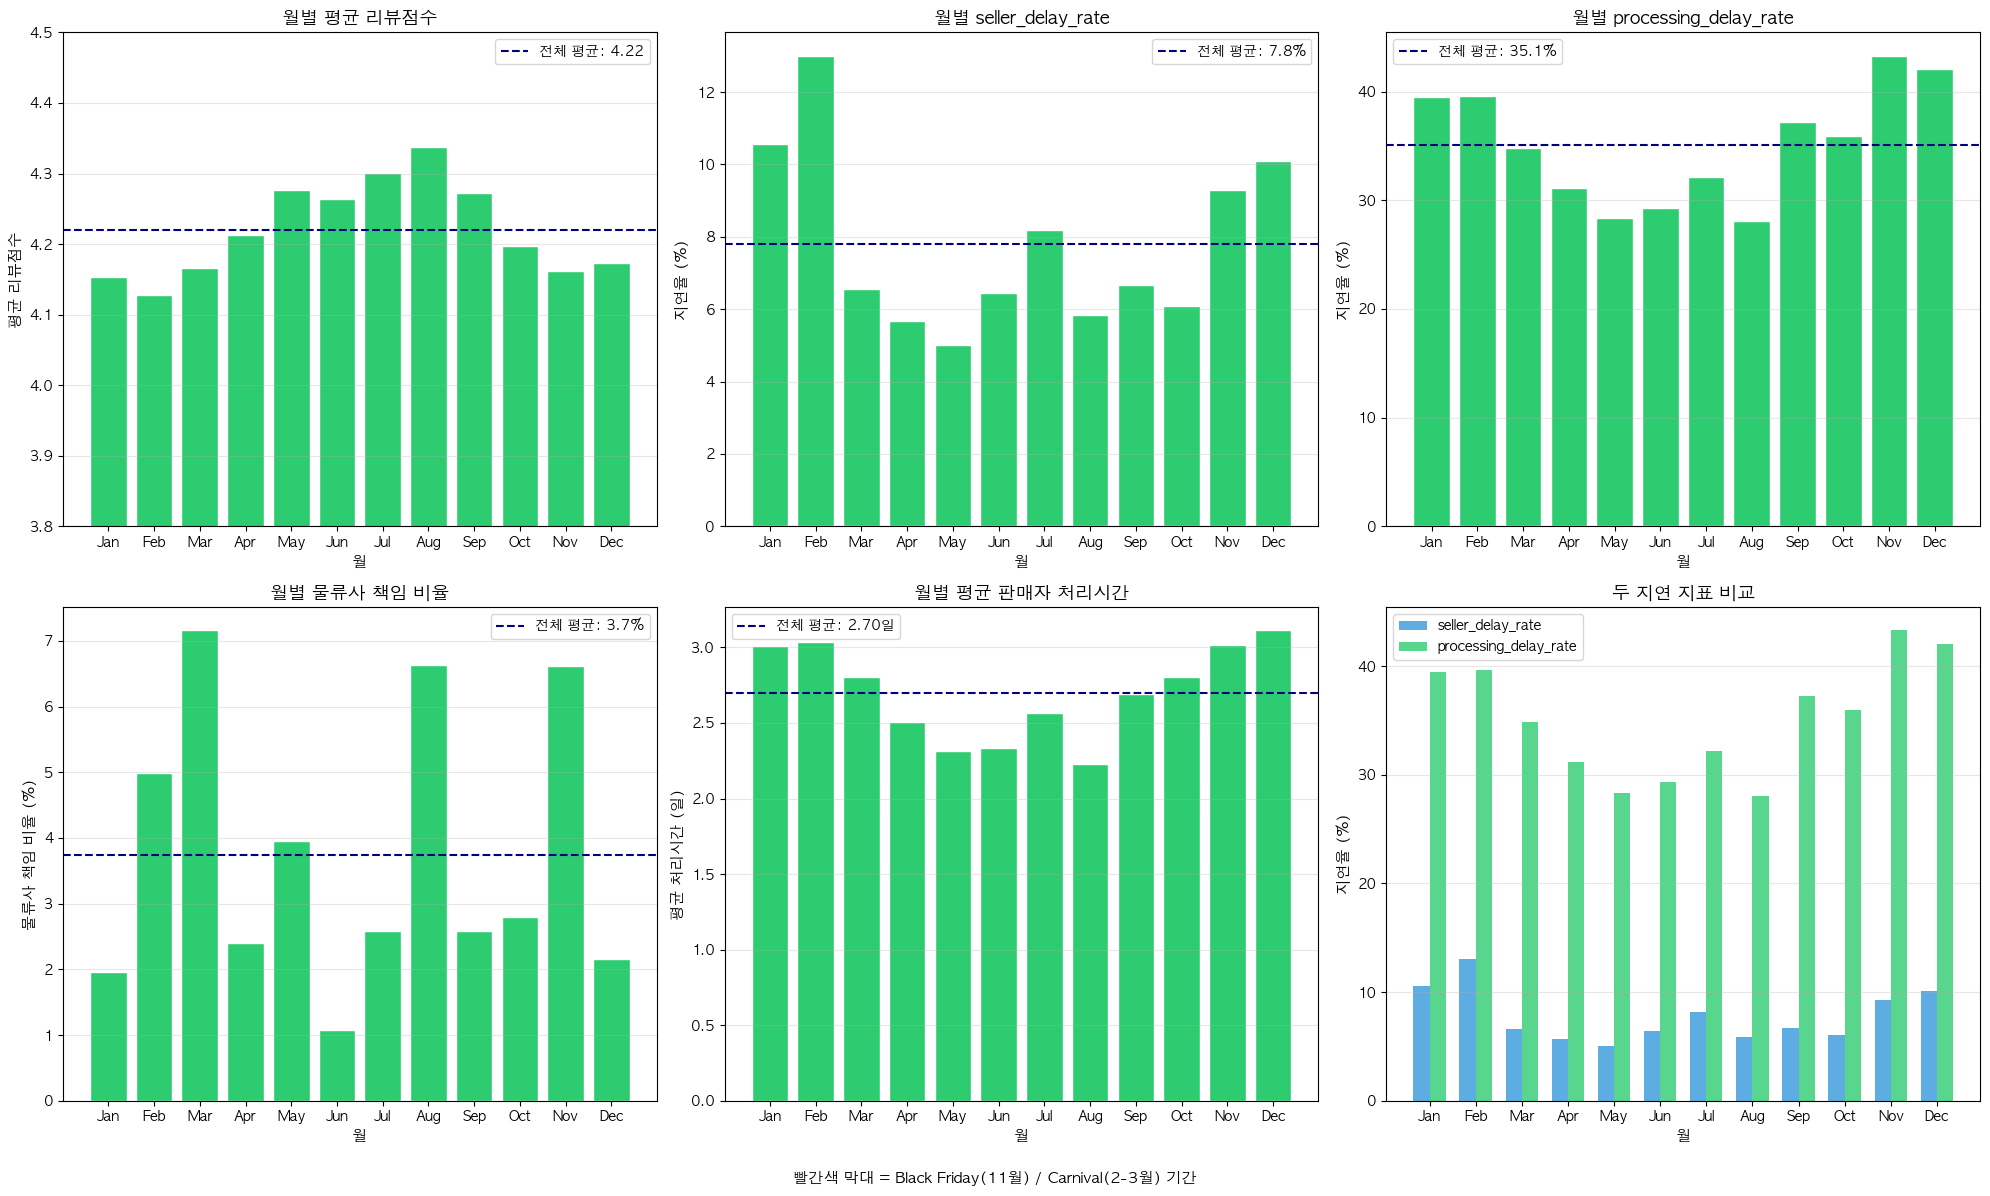

In [214]:
# 월별 시각화
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 색상 설정: Black Friday(11월), Carnival(2-3월) 강조
colors = ['#2ecc71' if m not in ['Feb', 'Mar', 'Nov'] else '#2ecc71' 
          for m in monthly_stats.index]

# 1. 월별 평균 리뷰점수
ax1 = axes[0, 0]
bars1 = ax1.bar(monthly_stats.index, monthly_stats['avg_review_score'], color=colors, edgecolor='white')
ax1.axhline(monthly_stats['avg_review_score'].mean(), color='navy', linestyle='--', 
            label=f'전체 평균: {monthly_stats["avg_review_score"].mean():.2f}')
ax1.set_xlabel('월', fontsize=11)
ax1.set_ylabel('평균 리뷰점수', fontsize=11)
ax1.set_title('월별 평균 리뷰점수', fontsize=13, fontweight='bold')
ax1.set_ylim([3.8, 4.5])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. 월별 seller_delay_rate
ax2 = axes[0, 1]
bars2 = ax2.bar(monthly_stats.index, monthly_stats['seller_delay_rate'] * 100, color=colors, edgecolor='white')
ax2.axhline(monthly_stats['seller_delay_rate'].mean() * 100, color='navy', linestyle='--',
            label=f'전체 평균: {monthly_stats["seller_delay_rate"].mean()*100:.1f}%')
ax2.set_xlabel('월', fontsize=11)
ax2.set_ylabel('지연율 (%)', fontsize=11)
ax2.set_title('월별 seller_delay_rate', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. 월별 processing_delay_rate
ax3 = axes[0, 2]
bars3 = ax3.bar(monthly_stats.index, monthly_stats['processing_delay_rate'] * 100, color=colors, edgecolor='white')
ax3.axhline(monthly_stats['processing_delay_rate'].mean() * 100, color='navy', linestyle='--',
            label=f'전체 평균: {monthly_stats["processing_delay_rate"].mean()*100:.1f}%')
ax3.set_xlabel('월', fontsize=11)
ax3.set_ylabel('지연율 (%)', fontsize=11)
ax3.set_title('월별 processing_delay_rate', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. 월별 물류사 책임 비율
ax4 = axes[1, 0]
bars4 = ax4.bar(monthly_stats.index, monthly_stats['logistics_fault_rate'] * 100, color=colors, edgecolor='white')
ax4.axhline(monthly_stats['logistics_fault_rate'].mean() * 100, color='navy', linestyle='--',
            label=f'전체 평균: {monthly_stats["logistics_fault_rate"].mean()*100:.1f}%')
ax4.set_xlabel('월', fontsize=11)
ax4.set_ylabel('물류사 책임 비율 (%)', fontsize=11)
ax4.set_title('월별 물류사 책임 비율', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. 월별 평균 판매자 처리시간
ax5 = axes[1, 1]
bars5 = ax5.bar(monthly_stats.index, monthly_stats['avg_seller_processing'], color=colors, edgecolor='white')
ax5.axhline(monthly_stats['avg_seller_processing'].mean(), color='navy', linestyle='--',
            label=f'전체 평균: {monthly_stats["avg_seller_processing"].mean():.2f}일')
ax5.set_xlabel('월', fontsize=11)
ax5.set_ylabel('평균 처리시간 (일)', fontsize=11)
ax5.set_title('월별 평균 판매자 처리시간', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. 두 지표 비교 (라인 차트)
ax6 = axes[1, 2]
x = range(len(monthly_stats.index))
width = 0.35
ax6.bar([i - width/2 for i in x], monthly_stats['seller_delay_rate'] * 100, width, 
        label='seller_delay_rate', color='#3498db', alpha=0.8)
ax6.bar([i + width/2 for i in x], monthly_stats['processing_delay_rate'] * 100, width, 
        label='processing_delay_rate', color='#2ecc71', alpha=0.8)
ax6.set_xlabel('월', fontsize=11)
ax6.set_ylabel('지연율 (%)', fontsize=11)
ax6.set_title('두 지연 지표 비교', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(monthly_stats.index)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 범례 추가
fig.text(0.5, 0.01, '빨간색 막대 = Black Friday(11월) / Carnival(2-3월) 기간', 
         ha='center', fontsize=11, style='italic')

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


In [215]:
# 통계적 유의성 검정: 특수기간 vs 일반기간 (물류사 책임 제외)
from scipy.stats import ttest_ind, mannwhitneyu

print("=" * 80)
print("통계적 유의성 검정: 특수기간 vs 일반기간")
print("=" * 80)

# 물류사 책임 제외한 데이터만 사용
analysis_df = merged_df[merged_df['is_logistics_fault'] == False].copy()

# 데이터 분리
normal_data = analysis_df[analysis_df['period_type'] == 'Normal']
special_data = analysis_df[analysis_df['period_type'] != 'Normal']
bf_data = analysis_df[analysis_df['is_black_friday'] == True]
carnival_data = analysis_df[analysis_df['is_carnival'] == True]

# 1. 리뷰점수 t-test
print("\n[1] 리뷰점수 비교")
print("-" * 60)

# Normal vs Black Friday
if len(bf_data) > 0:
    t_stat, p_value = ttest_ind(normal_data['review_score'].dropna(), 
                                 bf_data['review_score'].dropna())
    print(f"Normal vs Black Friday:")
    print(f"  Normal 평균: {normal_data['review_score'].mean():.4f}")
    print(f"  Black Friday 평균: {bf_data['review_score'].mean():.4f}")
    print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")
    print(f"  -> {'유의한 차이 있음 (p<0.05)' if p_value < 0.05 else '유의한 차이 없음'}")

# Normal vs Carnival
if len(carnival_data) > 0:
    t_stat, p_value = ttest_ind(normal_data['review_score'].dropna(), 
                                 carnival_data['review_score'].dropna())
    print(f"\nNormal vs Carnival:")
    print(f"  Normal 평균: {normal_data['review_score'].mean():.4f}")
    print(f"  Carnival 평균: {carnival_data['review_score'].mean():.4f}")
    print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")
    print(f"  -> {'유의한 차이 있음 (p<0.05)' if p_value < 0.05 else '유의한 차이 없음'}")

# 2. 두 지연율 비교
print("\n[2] seller_delay_rate 비교")
print("-" * 60)

for period_name, period_data in [('Black Friday', bf_data), ('Carnival', carnival_data)]:
    if len(period_data) > 0:
        normal_rate = normal_data['is_seller_delayed'].mean()
        period_rate = period_data['is_seller_delayed'].mean()
        
        from scipy.stats import chi2_contingency
        contingency = pd.crosstab(
            analysis_df['period_type'].isin([period_name]),
            analysis_df['is_seller_delayed']
        )
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        print(f"\nNormal vs {period_name}:")
        print(f"  Normal 지연율: {normal_rate:.2%}")
        print(f"  {period_name} 지연율: {period_rate:.2%}")
        print(f"  Chi-square: {chi2:.4f}, p-value: {p_value:.4e}")
        print(f"  -> {'유의한 차이 있음 (p<0.05)' if p_value < 0.05 else '유의한 차이 없음'}")

print("\n[3] processing_delay_rate 비교")
print("-" * 60)

for period_name, period_data in [('Black Friday', bf_data), ('Carnival', carnival_data)]:
    if len(period_data) > 0:
        normal_rate = normal_data['is_processing_delayed'].mean()
        period_rate = period_data['is_processing_delayed'].mean()
        
        contingency = pd.crosstab(
            analysis_df['period_type'].isin([period_name]),
            analysis_df['is_processing_delayed']
        )
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        print(f"\nNormal vs {period_name}:")
        print(f"  Normal 지연율: {normal_rate:.2%}")
        print(f"  {period_name} 지연율: {period_rate:.2%}")
        print(f"  Chi-square: {chi2:.4f}, p-value: {p_value:.4e}")
        print(f"  -> {'유의한 차이 있음 (p<0.05)' if p_value < 0.05 else '유의한 차이 없음'}")


통계적 유의성 검정: 특수기간 vs 일반기간

[1] 리뷰점수 비교
------------------------------------------------------------
Normal vs Black Friday:
  Normal 평균: 4.2301
  Black Friday 평균: 4.1418
  t-statistic: 1.8416, p-value: 6.5541e-02
  -> 유의한 차이 없음

Normal vs Carnival:
  Normal 평균: 4.2301
  Carnival 평균: 4.1081
  t-statistic: 3.1018, p-value: 1.9239e-03
  -> 유의한 차이 있음 (p<0.05)

[2] seller_delay_rate 비교
------------------------------------------------------------

Normal vs Black Friday:
  Normal 지연율: 7.39%
  Black Friday 지연율: 13.56%
  Chi-square: 32.0376, p-value: 1.5122e-08
  -> 유의한 차이 있음 (p<0.05)

Normal vs Carnival:
  Normal 지연율: 7.39%
  Carnival 지연율: 22.55%
  Chi-square: 309.7071, p-value: 2.5295e-69
  -> 유의한 차이 있음 (p<0.05)

[3] processing_delay_rate 비교
------------------------------------------------------------

Normal vs Black Friday:
  Normal 지연율: 33.52%
  Black Friday 지연율: 59.48%
  Chi-square: 186.2396, p-value: 2.1047e-42
  -> 유의한 차이 있음 (p<0.05)

Normal vs Carnival:
  Normal 지연율: 33.52%
  Carnival 

### 특수 시즌(이벤트)이 판매 및 배송 성과에 미치는 영향

**데이터 해석 및 인사이트**

**블랙프라이데이**

* 주문 폭주로 인해 판매자의 처리 속도가 평소보다 현저히 느려짐(지연율 1.8배 증가)
* 다만, 배송 지연에도 불구하고 리뷰 평점에는 통계적으로 유의미한 하락이 없음.
* **원인 추론:** 높은 할인율과 이벤트 특수성으로 인해 고객들의 **배송 지연에 대한 허용치가 높아짐.** "싸게 샀으니 조금 늦어도 괜찮다"는 심리가 작용함.

**카니발**

* 브라질 최대 연휴로 판매자들이 휴무에 들어가면서, 발송 기한을 어기는 비율이 평소의 **3배**로 치솟음.
* 리뷰 평점이 통계적으로 유의미하게 하락함.
* 순 물량 과다로 인한 지연이 아니라, **'판매자 휴무로 인한 무응답/미발송'** 이 주원인이므로 고객 경험이 크게 훼손됨.

**결론**                                                              
                                                                            
- Option A:
  - 전략: 특수 기간(is_black_friday, is_carnival) 데이터를 학습에서 제외
  - 이유: 외부 요인(물류 대란, 연휴)에 의한 노이즈를 제거하고, 판매자가 통제 가능한 평상시의 운영 능력만 공정하게 평가하기 위함.
- Option B: 
  - 전략: 특수 기간 데이터를 포함하되, is_black_friday, is_carnival 파생 변수를 피처로 반드시 추가.
  - 이유: 단순한 '월' 정보보다 구체적인 이벤트 여부가 지연과 평점 하락을 설명하는 가장 강력한 변수이기 때문.

---
## 2-2. 카테고리 피처 검증: 카테고리별 지연율이 리뷰에 미치는 영향

### 분석 조건
- 순수하게 **판매자 책임**으로 발생한 지연만 분석


In [216]:
# 물류사 책임 제외한 데이터만 필터링
seller_fault_df = merged_df[merged_df['is_logistics_fault'] == False].copy()

# 카테고리별 통계 (물류사 책임 제외)
category_stats = seller_fault_df.groupby('product_category_name_english').agg(
    total_orders=('order_id', 'count'),
    avg_review_score=('review_score', 'mean'),
    avg_seller_processing=('seller_processing_days', 'mean'),
    # seller_delay_days 관련
    avg_seller_delay=('seller_delay_days', 'mean'),
    seller_delay_rate=('is_seller_delayed', 'mean'),
    # processing_days_diff 관련
    avg_processing_diff=('processing_days_diff', 'mean'),
    processing_delay_rate=('is_processing_delayed', 'mean'),
    negative_review_rate=('review_score', lambda x: (x <= 2).sum() / len(x))
).round(4)

# 주문수 30건 이상인 카테고리만 분석
category_stats = category_stats[category_stats['total_orders'] >= 30].copy()
category_stats = category_stats.sort_values('seller_delay_rate', ascending=False)


In [217]:
# 카테고리별 지연율 vs 리뷰점수 상관관계 분석 
print("=" * 90)
print("카테고리별 지연율 <-> 리뷰점수 상관관계 분석")
print("=" * 90)

# 1. seller_delay_rate 기준(판매자가 약속을 어기는 비율이 높은 카테고리일수록 평점이 낮은가?)
print("\n[1] seller_delay_rate <-> 리뷰점수")
print("-" * 60)
corr_seller_delay, p_seller_delay = pearsonr(
    category_stats['seller_delay_rate'], 
    category_stats['avg_review_score']
)
spearman_seller_delay, sp_seller_delay = spearmanr(
    category_stats['seller_delay_rate'], 
    category_stats['avg_review_score']
)
print(f"  Pearson r: {corr_seller_delay:.4f} (p-value: {p_seller_delay:.4e})")
print(f"  Spearman r: {spearman_seller_delay:.4f} (p-value: {sp_seller_delay:.4e})")

# 2. processing_delay_rate 기준(약속은 안 어겼지만 일처리가 빠릿빠릿하지 못한 카테고리일수록 평점이 낮은가?)
print("\n[2] processing_delay_rate <-> 리뷰점수")
print("-" * 60)
corr_processing_delay, p_processing_delay = pearsonr(
    category_stats['processing_delay_rate'], 
    category_stats['avg_review_score']
)
spearman_processing_delay, sp_processing_delay = spearmanr(
    category_stats['processing_delay_rate'], 
    category_stats['avg_review_score']
)
print(f"  Pearson r: {corr_processing_delay:.4f} (p-value: {p_processing_delay:.4e})")
print(f"  Spearman r: {spearman_processing_delay:.4f} (p-value: {sp_processing_delay:.4e})")

# 결론
print("\n" + "-" * 60)
print("두 지표 비교 결론:")
print(f"  - seller_delay_rate와 리뷰점수: r={corr_seller_delay:.4f}")
print(f"  - processing_delay_rate와 리뷰점수: r={corr_processing_delay:.4f}")

# 기존 변수명 호환성 유지
corr_delay_review = corr_seller_delay
p_delay_review = p_seller_delay
spearman_delay_review = spearman_seller_delay
sp_delay_review = sp_seller_delay


카테고리별 지연율 <-> 리뷰점수 상관관계 분석

[1] seller_delay_rate <-> 리뷰점수
------------------------------------------------------------
  Pearson r: -0.3994 (p-value: 1.3024e-03)
  Spearman r: -0.3112 (p-value: 1.3832e-02)

[2] processing_delay_rate <-> 리뷰점수
------------------------------------------------------------
  Pearson r: -0.4994 (p-value: 3.5938e-05)
  Spearman r: -0.3110 (p-value: 1.3874e-02)

------------------------------------------------------------
두 지표 비교 결론:
  - seller_delay_rate와 리뷰점수: r=-0.3994
  - processing_delay_rate와 리뷰점수: r=-0.4994
